Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model works https://lettier.com/projects/lda-topic-modeling/
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics


# Latent Dirchilet Allocation Models (Learn)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a model available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Literary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for literary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelty of British women publishing novels during the early 19th century. 

Can we help close a literary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning algorithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

In [2]:
gensim.__version__

'3.8.1'

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chunks

In [3]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Activity**: update the function `tokenize` with any technique you have learned so far this week. 

In [4]:
# 1) Plain Python - ''.split command
# 2) Spacy - just the lemmas from the document
# 3) Gensim - simple_preprocess

STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [5]:
ex_str = "This is an example of Gensim simple_preprocess utility function."
tokenize(ex_str)

['example', 'gensim', 'utility', 'function']

In [6]:
# Addition code snippet from Bruno

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, stem_text
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_non_alphanum, remove_stopwords, strip_short

CUSTOM_FILTERS = [
    lambda x : x.lower(),         # Lowercase
    strip_multiple_whitespaces,   # Remove repeating white space
    strip_numeric,                # Remove numbers
    remove_stopwords,             # Remove stopwords
    strip_non_alphanum,           # Remove non-alpha numeric characters
    strip_short                   # Remove words less that 3 characters long
]

# Preprocess text with custom filters
preprocess_string(ex_str, CUSTOM_FILTERS)

['example', 'gensim', 'simple_preprocess', 'utility', 'function']

In [7]:
# Read in the data and tokenize

import os

def gather_data(path_to_data): 
    data = []
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    data.append(tokenize(str(text)))       
    return data

In [8]:
tokens = gather_data(path)

In [9]:
tokens[0][0:10]

['emma',
 'jane',
 'austen',
 'volume',
 'chapter',
 'emma',
 'woodhouse',
 'handsome',
 'clever',
 'rich']

In [10]:
# Remove \n character
ex_text = "this is a sample string with a \n newline character".replace('\n', '')
ex_text

'this is a sample string with a  newline character'

In [11]:
# Remove duplicate spaces
' '.join(ex_text.split())

'this is a sample string with a newline character'

## Follow Along

In [12]:
titles = [t[:-4] for t in os.listdir(path) if os.path.isdir(t) == False]

In [13]:
len(titles)

813

In [14]:
len(tokens)

813

### Author DataFrame


In [15]:
df = pd.DataFrame(index=titles, data={'tokens':tokens})

In [16]:
df.head()

,tokens
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo..."
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p..."
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be..."
Austen_Emma0003,"[native, highbury, born, respectable, family, ..."
Austen_Emma0004,"[mention, handsome, letter, weston, received, ..."


In [17]:
# Use index to map author book section

df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [18]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [19]:
#0 : CBronte
#1 : Austen
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [20]:
df.head()

,tokens,author,book,section
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo...",1,Emma,0
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p...",1,Emma,1
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be...",1,Emma,2
Austen_Emma0003,"[native, highbury, born, respectable, family, ...",1,Emma,3
Austen_Emma0004,"[mention, handsome, letter, weston, received, ...",1,Emma,4


In [21]:
df.tail()

,tokens,author,book,section
CBronte_Villette0170,"[think, sole, faithful, god, creatures, ferven...",0,Villette,170
CBronte_Villette0171,"[establishment, faubourg, goodness, accept, pr...",0,Villette,171
CBronte_Villette0172,"[assailable, magnificent, minded, grand, heart...",0,Villette,172
CBronte_Villette0173,"[grand, morning, dew, bathe, sunrise, course, ...",0,Villette,173
CBronte_Villette0174,"[autumn, ere, mists, november, come, school, f...",0,Villette,174


### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our function. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this function later on. 

In [22]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    tokens = tokenize(text)
                yield tokens

In [23]:
streaming_data = doc_stream(path)

In [24]:
type(streaming_data)

generator

In [ ]:
# gather_data => returns a list
# doc_stream => returns a generator

In [25]:
next(streaming_data) # Returns one document at a time from the generator

['emma',
 'jane',
 'austen',
 'volume',
 'chapter',
 'emma',
 'woodhouse',
 'handsome',
 'clever',
 'rich',
 'comfortable',
 'home',
 'happy',
 'disposition',
 'unite',
 'best',
 'blessings',
 'existence',
 'lived',
 'nearly',
 'years',
 'world',
 'little',
 'distress',
 'vex',
 'youngest',
 'daughters',
 'affectionate',
 'indulgent',
 'father',
 'consequence',
 'sister',
 'marriage',
 'mistress',
 'house',
 'early',
 'period',
 'mother',
 'died',
 'long',
 'ago',
 'indistinct',
 'remembrance',
 'caresses',
 'place',
 'supplied',
 'excellent',
 'woman',
 'governess',
 'fallen',
 'little',
 'short',
 'mother',
 'affection',
 'sixteen',
 'years',
 'miss',
 'taylor',
 'woodhouse',
 'family',
 'governess',
 'friend',
 'fond',
 'daughters',
 'particularly',
 'emma',
 'intimacy',
 'sisters',
 'miss',
 'taylor',
 'ceased',
 'hold',
 'nominal',
 'office',
 'governess',
 'mildness',
 'temper',
 'hardly',
 'allowed',
 'impose',
 'restraint',
 'shadow',
 'authority',
 'long',
 'passed',
 'away',


### Gensim LDA Topic Modeling

In [26]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [27]:
id2word.token2id['england']

3986

In [28]:
# produces Bag of Words representation
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(2753, 1), (3986, 3), (6601, 1), (6818, 1)]

In [29]:
import sys
print(sys.getsizeof(id2word))
print(sys.getsizeof(tokens))
# this is only 800 docs

56
7056


In [30]:
len(id2word.keys())

22095

In [31]:
# Let's remove extreme values from the dataset
# removes really
## Rare words
## Common words

id2word.filter_extremes(no_below=5, no_above=0.95)


In [32]:
len(id2word.keys())

8102

In [33]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although abstracted away - tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

### This is the main input to our LDA model

In [34]:
corpus[345][:10]
# this is the 345th section : first 10 tokens

[(0, 1),
 (2, 1),
 (11, 1),
 (21, 2),
 (32, 1),
 (34, 1),
 (35, 1),
 (37, 1),
 (53, 1),
 (54, 1)]

In [35]:
# We train the LDA model

lda = LdaMulticore(corpus=corpus,          # input(our data)
                   id2word=id2word,        # mapping that tells model which word(num) is which word
                   random_state=42,        # random state we like 42
                   num_topics = 15,        # 15 is our starting point we can change it
                   passes=10,              # we can adjust the num of passes
                   workers=12
                  )

In [36]:
# let's looks at which words have the highest probability on the topic

lda.print_topics()

[(0,
  '0.009*"monsieur" + 0.008*"little" + 0.008*"paul" + 0.006*"pelet" + 0.006*"madame" + 0.005*"vous" + 0.004*"thought" + 0.004*"est" + 0.004*"reuter" + 0.004*"like"'),
 (1,
  '0.009*"elinor" + 0.007*"marianne" + 0.006*"think" + 0.006*"time" + 0.005*"know" + 0.004*"man" + 0.004*"good" + 0.004*"sister" + 0.004*"little" + 0.004*"soon"'),
 (2,
  '0.007*"sir" + 0.007*"jane" + 0.005*"know" + 0.005*"good" + 0.005*"like" + 0.004*"thought" + 0.004*"rochester" + 0.004*"long" + 0.004*"little" + 0.004*"shall"'),
 (3,
  '0.006*"little" + 0.005*"like" + 0.004*"thought" + 0.004*"day" + 0.004*"long" + 0.004*"good" + 0.003*"time" + 0.003*"come" + 0.003*"heart" + 0.003*"madame"'),
 (4,
  '0.005*"little" + 0.005*"white" + 0.004*"like" + 0.004*"rochester" + 0.004*"long" + 0.004*"good" + 0.004*"eye" + 0.004*"think" + 0.004*"room" + 0.003*"time"'),
 (5,
  '0.009*"little" + 0.008*"like" + 0.007*"graham" + 0.007*"bretton" + 0.006*"know" + 0.006*"miss" + 0.005*"think" + 0.005*"papa" + 0.005*"good" + 0.004*

In [37]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [38]:
topics = [' '.join(t[0:5]) for t in words]

In [39]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
monsieur little paul pelet madame

------ Topic 1 ------
elinor marianne think time know

------ Topic 2 ------
sir jane know good like

------ Topic 3 ------
little like thought day long

------ Topic 4 ------
little white like rochester long

------ Topic 5 ------
little like graham bretton know

------ Topic 6 ------
elizabeth miss darcy bennet bingley

------ Topic 7 ------
like little night long time

------ Topic 8 ------
think little sir miss come

------ Topic 9 ------
miss time elinor know house

------ Topic 10 ------
emma miss weston elton knightley

------ Topic 11 ------
madame dr little john know

------ Topic 12 ------
john st hand little jane

------ Topic 13 ------
hand thought madame good like

------ Topic 14 ------
like little time hunsden thought



## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [40]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [41]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pyLDAvis.gensim.prepare(lda, corpus, id2word)

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.145086  0.009637       1        1  17.776601
10     0.157731  0.018137       2        1  13.188303
6      0.167000 -0.001689       3        1  12.624997
7     -0.066395 -0.019818       4        1  11.432452
5     -0.008240 -0.013422       5        1   7.893301
2     -0.003025 -0.024663       6        1   7.645911
14    -0.060196 -0.027091       7        1   6.496879
12    -0.053950 -0.002699       8        1   5.953220
0     -0.103418  0.116742       9        1   4.867012
3     -0.046005  0.003583      10        1   3.680607
11    -0.055329  0.046049      11        1   3.218541
9      0.036701 -0.015517      12        1   2.411993
4     -0.069860 -0.118008      13        1   1.383578
13    -0.013535  0.047659      14        1   1.119758
8     -0.026566 -0.018901      15        1   0.306847, topic_info=           Term         Freq        Total Category  logprob  loglift
86         emma   883.000000   883.000000  Default  30.0000  30.0000
1339  elizabeth   638.000000   638.000000  Default  29.0000  29.0000
5851     elinor   675.000000   675.000000  Default  28.0000  28.0000
301      weston   450.000000   450.000000  Default  27.0000  27.0000
183        miss  1541.000000  1541.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
116       great     2.807119   829.533333  Topic15  -5.8366   0.0979
2340      chair     2.274101   168.705875  Topic15  -6.0472   1.4800
987        eyes     2.335676   635.316203  Topic15  -6.0205   0.1808
63          day     2.348251  1053.977304  Topic15  -6.0151  -0.3201
403        like     2.370495  1319.691839  Topic15  -6.0057  -0.5355

[1142 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
792       1  0.061428       abbey
792       2  0.890706       abbey
6814      6  0.864365    absolved
6080      6  0.770853  abstracted
6080      8  0.128475  abstracted
...     ...       ...         ...
7898      5  0.103748     zoraide
7898      7  0.034583     zoraide
7898      9  0.760822     zoraide
7898     11  0.069166     zoraide
7898     15  0.034583     zoraide

[4457 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 7, 8, 6, 3, 15, 13, 1, 4, 12, 10, 5, 14, 9])

### Overall Model / Documents

In [42]:
# pass in doc 0
lda[corpus[0]]

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 0.52467906), (5, 0.019031946), (10, 0.45443514)]

In [43]:
distro = [lda[d] for d in corpus]

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# gives you the distribution for each document
distro[0]

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 0.5246731), (5, 0.019040857), (10, 0.45443216)]

In [45]:
# iterate over distribution 
# fill in with 0 to populate dataframe

distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
len(new_distro)

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


813

In [47]:
df.head()

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tokens,author,book,section
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo...",1,Emma,0
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p...",1,Emma,1
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be...",1,Emma,2
Austen_Emma0003,"[native, highbury, born, respectable, family, ...",1,Emma,3
Austen_Emma0004,"[mention, handsome, letter, weston, received, ...",1,Emma,4


In [48]:
# Fill df with new_distro

df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
df.head()

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,monsieur little paul pelet madame,elinor marianne think time know,sir jane know good like,little like thought day long,little white like rochester long,little like graham bretton know,elizabeth miss darcy bennet bingley,like little night long time,think little sir miss come,miss time elinor know house,emma miss weston elton knightley,madame dr little john know,john st hand little jane,hand thought madame good like,like little time hunsden thought,author
Austen_Emma0000,0.0,0.524679,0.0,0.0,0.0,0.019032,0.0,0.0,0.0,0.000000,0.454435,0.0,0.0,0.0,0.0,Austen
Austen_Emma0001,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.026248,0.971309,0.0,0.0,0.0,0.0,Austen
Austen_Emma0002,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.997562,0.0,0.0,0.0,0.0,Austen
Austen_Emma0003,0.0,0.428409,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.569459,0.0,0.0,0.0,0.0,Austen
Austen_Emma0004,0.0,0.019121,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.978876,0.0,0.0,0.0,0.0,Austen


In [50]:
df.groupby('author').mean()

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,monsieur little paul pelet madame,elinor marianne think time know,sir jane know good like,little like thought day long,little white like rochester long,little like graham bretton know,elizabeth miss darcy bennet bingley,like little night long time,think little sir miss come,miss time elinor know house,emma miss weston elton knightley,madame dr little john know,john st hand little jane,hand thought madame good like,like little time hunsden thought
author,,,,,,,,,,,,,,,
Austen,0.000083,0.373590,0.003013,0.003411,0.000633,0.003734,0.287900,0.006786,0.000000,0.023369,0.287228,0.000000,0.000146,0.005595,0.001983
CBronte,0.081623,0.020283,0.143662,0.063030,0.023347,0.137508,0.004458,0.195182,0.007134,0.024015,0.002488,0.055221,0.109612,0.015182,0.114608


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text preprocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [51]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# Can take a long time to run.

warnings.filterwarnings("ignore", category=DeprecationWarning)


coherence_values = compute_coherence_values(dictionary=id2word, 
                                            corpus=corpus,
                                            start=5, 
                                            limit=40, 
                                            step=3,
                                            passes=5)

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,5,-0.738011
1,0,8,-0.727512
2,0,11,-0.706856
3,0,14,-0.802435
4,0,17,-0.754474


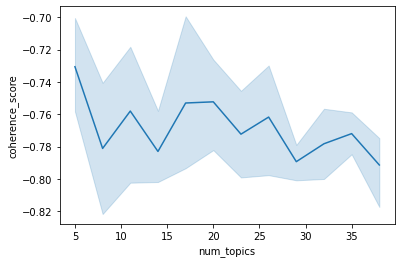

In [57]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [58]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

In [ ]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)